In [1]:
#importing packages
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from Utility.IO import *


#### Load Dictionary

In [2]:
dic=load_dictionary()

In [6]:
cat_list0=dic.category.unique()
cat_list=np.delete(cat_list0,[0,8])
cat_list

array([u'school', u'admissions', u'academics', u'student', u'cost', u'aid',
       u'completion', u'earnings'], dtype=object)

#### Read data and transform

In [21]:
rpyrt0=get_rpyrt_by_class(1)

In [22]:
rpyrt=rpyrt0
y=rpyrt.RPY_1YR_RT
rpyrt.RPY_1YR_RT=np.log(y/(1-y))

In [ ]:
rpyrt.fillna(0,inplace=True)

In [121]:
np.exp(y)/(1+np.exp(y))

0        0.477044
1        0.608185
2        0.657534
3        0.657205
4        0.432048
5        0.667554
6        0.482759
7        0.700599
8        0.588835
9        0.817726
10       0.836735
11       0.363208
13       0.480594
14       0.560976
15       0.506073
16       0.569128
19       0.571429
21       0.355231
22       0.722222
23       0.689655
25       0.615256
27       0.504889
28       0.497844
29       0.678571
31       0.601439
33       0.516484
34       0.251524
35       0.655889
36       0.714286
37       0.526891
           ...   
43858    0.371747
43859    0.575792
43860    0.575792
43861    0.446970
43862    0.181826
43863    0.181826
43864    0.181826
43865    0.181826
43866    0.181826
43867    0.123188
43868    0.123188
43869    0.181826
43870    0.181826
43871    0.181826
43872    0.181826
43873    0.181826
43874    0.181826
43875    0.181826
43876    0.181826
43877    0.181826
43878    0.181826
43879    0.181826
43880    0.181826
43881    0.181826
43882    0

#### Variable Screening

In [24]:
screen=prescreening_by_class(rpyrt,y=1,nobs=500)

In [25]:
dic=dic.loc[dic['name'].isin(screen),:]

In [26]:
X=rpyrt[screen].fillna(0)
print X.shape
X=X/X.std()
print X.shape

(35027, 500)
(35027, 500)


### PCA

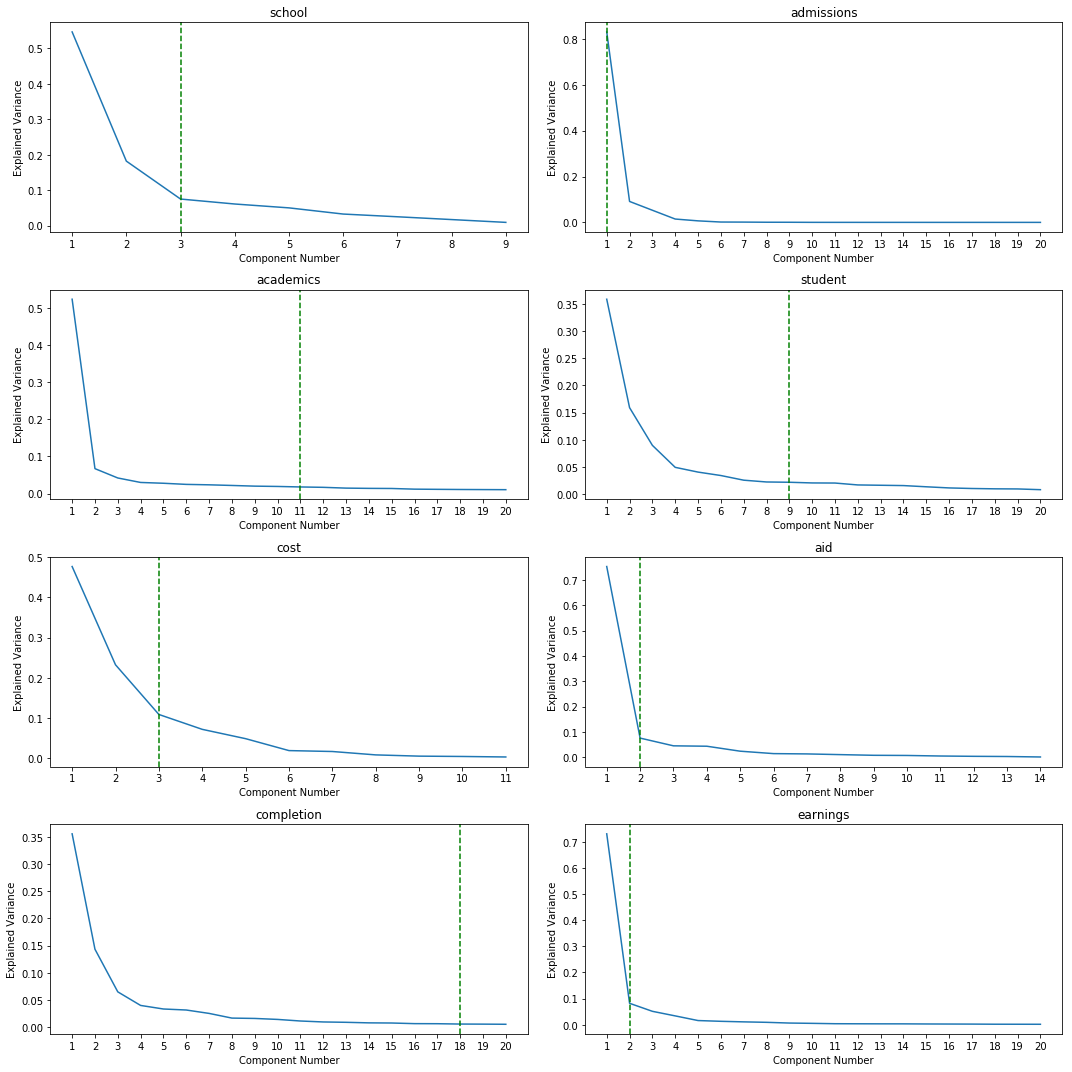

In [137]:
#pca = PCA(n_components=3)
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(15,15))
ncom=[3,2,4,7,3,2,12,5]
i=0
for cat in cat_list:
    variables=dic.loc[dic.category==cat,'name']
    XX=X.loc[:,np.array(variables)].fillna(0)
    pca=PCA(n_components=min(XX.shape[1],20))
    pca.fit(XX)
    ax=axes[i/2,i%2]
    ax.plot(range(1,(pca.n_components_+1)),pca.explained_variance_ratio_,label="x")
    ax.set_xlabel('Component Number')
    ax.set_ylabel('Explained Variance')
    ax.set_xticks(range(1,(pca.n_components_+1)))
    ax.set_title(cat)
    ax.axvline(PCA(0.8).fit(XX).n_components_,linestyle='--',color='g')
    #ax.axvline(ncom[i],linestyle='--',color='g')
    i=i+1
plt.tight_layout()

In [127]:
[i for i, a in enumerate([11,21,31])]

[0, 1, 2]

### Linear Regression on PCA

In [144]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import cross_val_score
from sklearn.learning_curve import validation_curve
import statsmodels.formula.api as smf
import math

def rms_error(model, X, y):
    y_pred = model.predict(X)
    p_pred=np.exp(y_pred)/(1+np.exp(y_pred))
    p=np.exp(y)/(1+np.exp(y))
    return np.sqrt(np.mean((p - p_pred) ** 2))

def rms_error0(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

#pca = PCA(n_components=3)
vars=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]
cv=10
val_train=np.zeros((len(vars),cv))
val_test=np.zeros((len(vars),cv))
for i, var in enumerate(vars):
    X_trans=None
    for cat in cat_list:
        variables=dic.loc[dic.category==cat,'name']
        XX=X.loc[:,np.array(variables)].fillna(0)
        pca=PCA(var)
        XX_trans=pca.fit_transform(XX)
        XX_trans=pd.DataFrame(XX_trans)
        X_trans=pd.concat([X_trans,XX_trans],axis=1)    
    y=rpyrt.RPY_1YR_RT
    model=LinearRegression()
    model.fit(X_trans,y)
    model.score(X_trans,y)
    #cv=cross_val_score(LinearRegression(), X_trans, y ,cv=10)
    #print cv.mean()
    val_train[i,:], val_test[i,:]=validation_curve(LinearRegression(), X_trans, y, 'fit_intercept',[True],cv=10,scoring=rms_error)


In [150]:
len(val_train.mean(1))

11

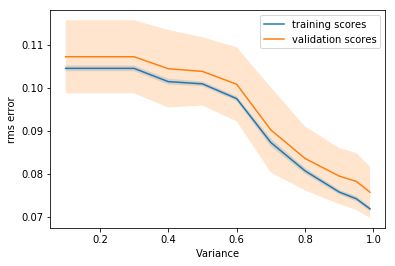

In [152]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(vars, val_train, label='training scores')
plot_with_err(vars, val_test, label='validation scores')
plt.xlabel('Variance'); plt.ylabel('rms error')
plt.legend();

### Random Forest

In [153]:
from sklearn.ensemble import RandomForestRegressor

In [154]:
rf=RandomForestRegressor(10,oob_score = True).fit(X, y)

In [ ]:
cv=cross_val_score(rf, X_trans, y ,cv=10,scoring=rms_error)
print cv.mean()

In [155]:
#sorted(rf.feature_importances_,reverse=True)
order_importance=sorted(range(len(rf.feature_importances_)), key=rf.feature_importances_.__getitem__,reverse=True)
feature_rf=X.columns[order_importance[0:20]]
#rf.feature_importances_[3]
#rf.feature_importances_.mean()

Index([u'FAMINC', u'PELL_EVER', u'FEMALE_DEBT_MDN', u'Year', u'MD_FAMINC',
       u'UGDS_BLACK', u'FIRSTGEN_WDRAW_ORIG_YR2_RT', u'INC_PCT_LO',
       u'WDRAW_ORIG_YR2_RT', u'PELL_ENRL_ORIG_YR2_RT', u'AGE_ENTRY',
       u'PCTPELL', u'NOT1STGEN_WDRAW_ORIG_YR2_RT', u'MALE_WDRAW_ORIG_YR3_RT',
       u'WDRAW_2YR_TRANS_YR3_RT', u'WDRAW_2YR_TRANS_YR2_RT', u'INC_PCT_M2',
       u'WDRAW_ORIG_YR3_RT', u'UGDS_BLACKNH', u'MARRIED'],
      dtype='object')

In [161]:
feature_rf=X.columns[order_importance[0:20]]
dic.loc[dic.name.isin(feature_rf),['desc','name']]

,desc,name
531,Total share of enrollment of undergraduate deg...,UGDS_BLACK
540,Total share of enrollment of undergraduate deg...,UGDS_BLACKNH
624,Percentage of undergraduates who receive a Pel...,PCTPELL
675,Percent withdrawn from original institution wi...,WDRAW_ORIG_YR2_RT
677,Percent who transferred to a 2-year institutio...,WDRAW_2YR_TRANS_YR2_RT
782,Percent of students who received a Pell Grant ...,PELL_ENRL_ORIG_YR2_RT
831,Percent of first-generation students withdrawn...,FIRSTGEN_WDRAW_ORIG_YR2_RT
844,Percent of not-first-generation students withd...,NOT1STGEN_WDRAW_ORIG_YR2_RT
857,Percent withdrawn from original institution wi...,WDRAW_ORIG_YR3_RT
859,Percent who transferred to a 2-year institutio...,WDRAW_2YR_TRANS_YR3_RT


In [156]:
dic.head()

,desc,category,name
2,6-digit OPE ID for institution,root,OPEID6
10,Predominant degree awarded (recoded 0s and 4s),school,SCH_DEG
12,Flag for main campus,school,MAIN
14,Number of branch campuses,school,NUMBRANCH
15,Predominant undergraduate degree awarded\n 0 N...,school,PREDDEG


### Elatstic Net

[  4.74955744e+02   4.13092284e+02   3.59286602e+02   3.12489164e+02
   2.71787139e+02   2.36386593e+02   2.05597003e+02   1.78817789e+02
   1.55526593e+02   1.35269099e+02   1.17650164e+02   1.02326113e+02
   8.89980348e+01   7.74059520e+01   6.73237495e+01   5.85547640e+01
   5.09279476e+01   4.42945316e+01   3.85251247e+01   3.35071888e+01
   2.91428440e+01   2.53469595e+01   2.20454928e+01   1.91740453e+01
   1.66766068e+01   1.45044621e+01   1.26152415e+01   1.09720937e+01
   9.54296755e+00   8.29998651e+00   7.21890499e+00   6.27863541e+00
   5.46083689e+00   4.74955744e+00   4.13092284e+00   3.59286602e+00
   3.12489164e+00   2.71787139e+00   2.36386593e+00   2.05597003e+00
   1.78817789e+00   1.55526593e+00   1.35269099e+00   1.17650164e+00
   1.02326113e+00   8.89980348e-01   7.74059520e-01   6.73237495e-01
   5.85547640e-01   5.09279476e-01   4.42945316e-01   3.85251247e-01
   3.35071888e-01   2.91428440e-01   2.53469595e-01   2.20454928e-01
   1.91740453e-01   1.66766068e-01

(-2.9766531440245281,
 3.6233468559754725,
 -0.16945913577331453,
 0.33104373820362509)

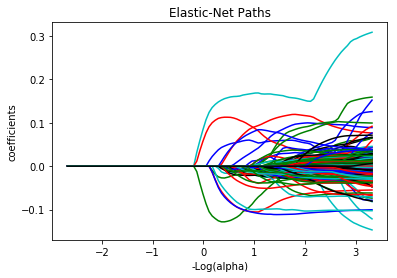

In [117]:
from sklearn.linear_model import lasso_path, enet_path
from itertools import cycle
alphas_enet, coefs_enet, _ = enet_path(
    X, y, eps=1e-6, l1_ratio=0.5, fit_intercept=True)
print alphas_enet
print coefs_enet.shape

plt.figure(1)
ax = plt.gca()

colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_e, c in zip(coefs_enet, colors):
    plt.plot(neg_log_alphas_enet, coef_e, c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic-Net Paths')
plt.axis('tight')

In [104]:
from sklearn.linear_model import ElasticNetCV
regr = ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1],cv=5, random_state=0,eps=1e-4)
regr.fit(X, y)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.0001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=0, selection='cyclic', tol=0.0001,
       verbose=0)

In [ ]:
model_en=ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1],cv=5, random_state=0,eps=1e-4)
cv=cross_val_score(model_en, X_trans, y ,cv=10,scoring=rms_error)
print cv.mean()

In [167]:
print sum(regr.coef_!=0)
print regr.alpha_
print regr.l1_ratio
order_coef=sorted(range(len(regr.coef_)), key=abs(regr.coef_).__getitem__,reverse=True)
old=new
new=X.columns[order_coef[0:20]]
list(set(old).intersection(new))
#regr.l1_ratio

341
0.000583002017988
[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]


['INC_PCT_M2',
 'PCT25_EARN_WNE_P6',
 'INC_PCT_H1',
 'MN_EARN_WNE_P10',
 'MN_EARN_WNE_P6',
 'MN_EARN_WNE_P7',
 'APPL_SCH_PCT_GE5',
 'NOPELL_DEBT_MDN',
 'FAMINC',
 'MN_EARN_WNE_MALE1_P10']

In [168]:
feature_en=X.columns[order_coef[0:20]]
dic.loc[dic.name.isin(feature_en),['desc','name']]

,desc,name
531,Total share of enrollment of undergraduate deg...,UGDS_BLACK
540,Total share of enrollment of undergraduate deg...,UGDS_BLACKNH
675,Percent withdrawn from original institution wi...,WDRAW_ORIG_YR2_RT
857,Percent withdrawn from original institution wi...,WDRAW_ORIG_YR3_RT
1640,Percentage of students who are financially dep...,DEP_INC_PCT_LO
1641,Percentage first-generation students,PAR_ED_PCT_1STGEN
1643,Aided students with family incomes between $48...,INC_PCT_M2
1644,Aided students with family incomes between $75...,INC_PCT_H1
1645,Aided students with family incomes between $11...,INC_PCT_H2
1660,Number of applications is greater than or equa...,APPL_SCH_PCT_GE5


In [169]:
 list(set(X.columns[order_coef[0:20]]).intersection(X.columns[order_importance[0:20]]))

['WDRAW_ORIG_YR2_RT',
 'INC_PCT_M2',
 'UGDS_BLACKNH',
 'FAMINC',
 'Year',
 'UGDS_BLACK',
 'WDRAW_ORIG_YR3_RT']